In [1]:
import sqlite3

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [2]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver(conn)

In [3]:
# from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatTongyi
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

# model = ChatOpenAI(model="gpt-4o",temperature=0)
model = ChatTongyi(model="qwen-plus", temperature=0)


class State(MessagesState):
    summary: str


# Define the logic to call the model
def call_model(state: State):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}


def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}


# Determine whether to end or summarize the conversation
def should_continue(state: State):
    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


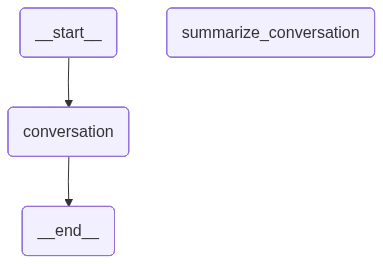

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='47acaf20-35ec-4cf0-9595-348ef7d1ebff'), AIMessage(content="Hi Lance! ٩(◕‿◕｡)۶ How's your day going? I'd love to hear what's on your mind or help with anything you need!", additional_kwargs={}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'stop', 'request_id': '11ea5590-bd46-471e-8fe4-528804c45170', 'token_usage': {'input_tokens': 13, 'output_tokens': 37, 'total_tokens': 50, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--57849513-051e-46df-901b-bea7112d31f4-0'), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='207015cf-989a-43a5-b875-3cdb96345e02'), AIMessage(content="Your name is Lance! I'm glad to remember that. 😊 Is there something special you'd like to talk about, Lance?", additional_kwargs={}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'stop', 'request_id': '8d143933-54f8-4c6b